# Preprocessing

## imports

In [17]:
import pandas as pd
import numpy as np
import datetime
# import python_ta as pta
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error

## constants

In [2]:
main_directory_crypto = 'klines/crypto/'

In [27]:
# MinMax Scaler
# Specify the minimum and maximum values for your features
feature_min = -100  # Minimum value is -100%
feature_max = 1000  # Maximum value is 1000%

# Create the scaler object
scaler = MinMaxScaler(feature_range=(-1, 1), clip=True)
scaler.min_, scaler.max_ = feature_min, feature_max

## helpers

In [3]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA
    """
    return values.ewm(alpha=1 / n, adjust=False).mean()

def percentage(f, t):
    return round((t/f - 1) * 100, 2)
    
def upwick(d):
    return percentage(max(d['open'], d['close']), d['high'])

def downwick(d):
    return percentage(min(d['open'], d['close']), d['high'])

# body

# range

def vwma(prices, volumes, window):
    """
    Calculate the Volume Weighted Moving Average (VWMA).
    
    Parameters:
        prices (pandas.Series): Series of prices.
        volumes (pandas.Series): Series of volumes.
        window (int): Window size for the moving average.
    
    Returns:
        pandas.Series: Volume Weighted Moving Average (VWMA) values.
    """
    # Calculate typical price
    typical_price = (prices * volumes).sum() / volumes.sum()
    
    # Calculate VWMA
    vwma_values = pd.Series(index=prices.index)
    for i in range(len(prices) - window + 1):
        vwma_values.iloc[i + window - 1] = (prices.iloc[i:i+window] * volumes.iloc[i:i+window]).sum() / volumes.iloc[i:i+window].sum()
    
    return vwma_values

def generate_features(df):
    # SMA - Simple Moving Averages
    sma_periods = [10, 20, 50, 100, 200]
    for n in sma_periods:
        df['tmp'] = df['close'].rolling(window=n).mean()
        df[f'f_sma_{n}'] = percentage(df['tmp'], df['close'])

    # EMA - Exponential Moving Averages
    ema_periods = [10, 20, 50, 100, 200]
    for n in ema_periods:
        df['tmp'] = df['close'].ewm(span=n, adjust=False).mean()
        df[f'f_ema_{n}'] = percentage(df['tmp'], df['close'])

    # ATR - Average True Range
    atr_periods = [7,10,14,20,30]
    df['tr0'] = abs(df['high'] - df['low'])
    df['tr1'] = abs(df['high'] - df['close'].shift())
    df['tr2'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
    df.drop(['tr0', 'tr1','tr2'], axis=1, inplace=True)

    for n in atr_periods:
        df['tmp'] = wwma(df['tr'], n)
        df[f'f_atr_{n}'] = percentage(df['tmp'], df['tr'])
    df.drop('tr', axis=1, inplace=True)
    # df['f_atr_14'].apply(lambda x: np.log(x+100)-4.5).hist()

    # Candlestick info
    df['f_upwick'] = df.apply(upwick, axis=1)
    df['f_body'] = percentage(df['open'], df['close'])
    df['f_downwick'] = df.apply(downwick, axis=1)
    df['f_range'] = percentage(df['low'], df['high'])

    # SIMPLE VOLUME MOVING AVERAGE - [10,20,50]
    vma_periods = [10,20,50]
    for n in vma_periods:
        df['tmp'] = df['volume'].rolling(window=n).mean()
        df[f'f_vma_{n}'] = percentage(df['tmp'], df['volume'])
    

    # VWMA - Volume Weighted Moving Average
    vwma_periods = [10,20,50]
    for n in vwma_periods:
        df['tmp'] = vwma(df['close'], df['volume'], window=n)
        df[f'f_vwma_{n}'] = percentage(df['tmp'], df['close'])

    df.drop('tmp', axis=1, inplace=True)

    # 1-2-3 days ago features appended
    for col in df.columns:
        if not col.startswith('f'):
            continue    
        for i in range(1,4):
            df[f"{col}_{i}"] = df[col].shift(i)
        
    # Targets
    df['target_clf'] = (df['close'] >= df['close'].shift(1)).astype(int)
    df['target_clf'] = df['target_clf'].shift(-1)
    df['target_reg'] = percentage(df['close'].shift(1), df['close'])
    df['target_reg'] = df['target_reg'].shift(-1)
    
    
    return df

## test one ticker

In [16]:
s = 'INJBTC'
folder = s[0]
path = os.path.join(main_directory_crypto,folder,s + '.csv')
path

df = pd.read_csv(path)
df.sort_values('time', inplace=True)
df.drop_duplicates(inplace=True) # mostly stock data have duplicates
df = generate_features(df)
for col in df.columns:
    if not col.startswith('f'):
        continue    
    for i in range(1,4):
        df[f"{col}_{i}"] = df[col].shift(i)


df.dropna(inplace=True)

df

/var/folders/6w/2zf1qgfd4dqg3bs98bn50z4m0000gn/T/ipykernel_54178/3836025416.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vwma_values = pd.Series(index=prices.index)
/var/folders/6w/2zf1qgfd4dqg3bs98bn50z4m0000gn/T/ipykernel_54178/3319185808.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{i}"] = df[col].shift(i)


,time,open,high,low,close,volume,f_sma_10,f_sma_20,f_sma_50,f_sma_100,...,f_vwma_20_3_3,f_vwma_50_1_1,f_vwma_50_1_2,f_vwma_50_1_3,f_vwma_50_2_1,f_vwma_50_2_2,f_vwma_50_2_3,f_vwma_50_3_1,f_vwma_50_3_2,f_vwma_50_3_3
205,2021-12-07,0.000192,0.000196,0.000182,0.000182,27.84,-13.82,-14.76,-9.26,-15.03,...,5.40,-2.45,5.92,8.30,5.92,8.30,8.17,8.30,8.17,9.81
206,2021-12-08,0.000183,0.000191,0.000181,0.000190,14.36,-9.41,-11.39,-5.45,-11.38,...,3.37,-5.83,-2.45,5.92,-2.45,5.92,8.30,5.92,8.30,8.17
207,2021-12-09,0.000190,0.000192,0.000177,0.000178,15.19,-13.71,-16.74,-11.28,-16.84,...,3.01,-10.26,-5.83,-2.45,-5.83,-2.45,5.92,-2.45,5.92,8.30
208,2021-12-10,0.000178,0.000275,0.000176,0.000197,189.33,-2.39,-7.91,-1.56,-7.45,...,0.54,-6.53,-10.26,-5.83,-10.26,-5.83,-2.45,-5.83,-2.45,5.92
209,2021-12-11,0.000197,0.000201,0.000185,0.000188,32.39,-5.33,-11.77,-6.01,-11.51,...,-7.76,-12.40,-6.53,-10.26,-6.53,-10.26,-5.83,-10.26,-5.83,-2.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,2024-03-17,0.000625,0.000641,0.000606,0.000625,59.00,-1.15,-2.75,-10.24,-18.23,...,-9.75,-7.96,-3.84,-5.88,-3.84,-5.88,2.54,-5.88,2.54,-16.78
1037,2024-03-18,0.000625,0.000630,0.000562,0.000568,53.04,-9.58,-10.68,-17.71,-25.81,...,9.68,-9.70,-7.96,-3.84,-7.96,-3.84,-5.88,-3.84,-5.88,2.54
1038,2024-03-19,0.000568,0.000582,0.000543,0.000580,48.80,-7.43,-8.02,-15.31,-24.37,...,-0.13,-9.06,-9.70,-7.96,-9.70,-7.96,-3.84,-7.96,-3.84,-5.88
1039,2024-03-20,0.000579,0.000594,0.000549,0.000576,44.68,-7.93,-7.91,-15.22,-24.83,...,1.17,-16.56,-9.06,-9.70,-9.06,-9.70,-7.96,-9.70,-7.96,-3.84


## all files

In [8]:
def file_list(source):
    res = []
    for root, dirnames, filenames in os.walk(source):
        for filename in filenames:
            if filename.endswith('.csv'):
                res.append(os.path.join(root, filename))
    return res
all_files = file_list(main_directory_crypto)

# ['klines/crypto/R/RUNEUSDT.csv', ..]
len(all_files)

947

## Train, test (BTC) pairs

In [166]:
def get_all_df():
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    for file in tqdm(all_files):
        symbol = file.split('/')[-1].split('.')[0]
        if 'DOWN' in symbol:
            continue
        # if not symbol.endswith('USDT'):
        #     continue
        df = pd.read_csv(file)
        df['symbol'] = symbol
        df.sort_values('time', inplace=True)
        
        shape_before = df.shape[0]
        df.drop_duplicates(inplace=True) # mostly stock data have duplicates
        shape_after = df.shape[0] 
        
        diff = shape_before - shape_after
        if diff > 0:
            print(f"{symbol} - {diff} duplicates")
        df = generate_features(df)
        
        X_test = pd.concat([X_test, df.tail(1)])
        
        df.dropna(inplace=True)
        if not df.empty:
            # df.drop(['time', 'open', 'high', 'low','close','volume'], axis=1, inplace=True)
            # df.drop(['open', 'high', 'low'], axis=1, inplace=True)
            X_train = pd.concat([X_train, df])
    
    return X_train, X_test

df_train, df_test = get_all_df()


# df_test.dropna(inplace=True)

  0%|                                                                                                                                                  | 0/947 [00:00<?, ?it/s]/var/folders/6w/2zf1qgfd4dqg3bs98bn50z4m0000gn/T/ipykernel_54178/3836025416.py:36: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vwma_values = pd.Series(index=prices.index)
 42%|█████████████████████████████████████████████████████████                                                                               | 397/947 [03:48<07:11,  1.28it/s]/var/folders/6w/2zf1qgfd4dqg3bs98bn50z4m0000gn/T/ipykernel_54178/3836025416.py:38: RuntimeWarning: invalid value encountered in scalar divide
  vwma_values.iloc[i + window - 1] = (prices.iloc[i:i+window] * volumes.iloc[i:i+window]).sum() / volumes.iloc[i:i+window].sum()
100%|███████████████████████████████████████████████████████████████████████████████

In [167]:
# Raw copies
raw_train = df_train.copy()
raw_test = df_test.copy()

In [168]:
# Feature columns
feature_cols = [col for col in df_train.columns if col.startswith("f_")]

In [169]:
# MinMax Scale
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])
df_test[feature_cols] = scaler.fit_transform(df_test[feature_cols])

In [170]:
# Train
df_train.reset_index(drop=True, inplace=True)

# Test
max_time = df_test['time'].mode()[0]
df_test = df_test[df_test['time'] == max_time].reset_index(drop=True)
# remove nan rows for any feature columns
ind = df_test[feature_cols].dropna().index.values
df_test = df_test.iloc[ind]

# Val
# yesterday data for validation
yesterday = (datetime.datetime.strptime(max_time, '%Y-%m-%d') - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
df_yesterday = df_train[df_train['time'] == yesterday]
df_train = df_train.drop(index=df_yesterday.index)

In [171]:
df_train.shape, df_test.shape, df_yesterday.shape

((554546, 109), (603, 109), (603, 109))

# EDA

## Transform data

In [ ]:
def transform(df):
    
    for col in features_cols + ['target_reg']:
        df[col] = df[col].apply(lambda x: np.log1p(abs(x)) * (-1 if x < 0 else 1))
    return df
# transform target
# t['target_reg'] = t['target_reg'].apply(lambda x: np.log1p(abs(x)) * (-1 if x < 0 else 1))

# To transform back
# t['f_sma_10_exp'] = t['f_sma_10_log'].apply(lambda x: np.expm1(abs(x)) * (-1 if x < 0 else 1))

In [ ]:
for df in [df_train, df_yesterday, df_test]:
    df = transform(df)

In [ ]:
df_train[features_cols].describe()

In [ ]:
df_train.head()

In [ ]:
df_train.columns

<AxesSubplot: >

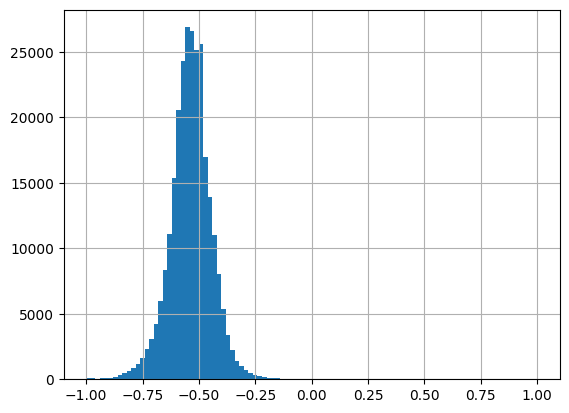

In [96]:
# Distribution check
df_train['f_vwma_50'].hist(bins=100)

# Catboost classifier

## Train test split data

In [172]:
X = df_train[feature_cols]
y = df_train[['target_clf', 'target_reg']]
target_clf = 'target_clf'
target_reg = 'target_reg'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [174]:
# Catboost classifier
# jupyter nbextension enable --py widgetsnbextension
clf = CatBoostClassifier(iterations=1000, 
                         depth=8, 
                         learning_rate=0.05, 
                         loss_function='Logloss',
                         random_seed=42)
clf.fit(X_train, y_train[target_clf], eval_set=(X_test, y_test[target_clf]), verbose=False)

y_clf_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test[target_clf], y_clf_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.60


In [100]:
print(classification_report(y_clf_pred, y_test[target_clf]))

              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64     25668
         1.0       0.68      0.65      0.66     28530

    accuracy                           0.65     54198
   macro avg       0.65      0.65      0.65     54198
weighted avg       0.65      0.65      0.65     54198



In [101]:
print(confusion_matrix(y_clf_pred, y_test[target_clf]))

[[16785  8883]
 [10006 18524]]


In [134]:
# Yesterday validation check
y_pred_yesterday = clf.predict(df_yesterday[feature_cols])

In [104]:
accuracy = accuracy_score(df_yesterday[target_clf], y_pred_yesterday)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.61


In [105]:
print(confusion_matrix(y_pred_yesterday, df_yesterday[target_clf]))

[[191  79]
 [ 54  15]]


In [135]:
df_yesterday['pred_clf'] = y_pred_yesterday

In [116]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
LR = LogisticRegression(max_iter=1000)
LR.fit(X_train, y_train[target_clf])

# Get probability estimates for the test set
y_prob = LR.predict_proba(X_test)
y_prob_0 = y_prob[:, 0]  # Probability estimates for class 0
y_prob_1 = y_prob[:, 1]  # Probability estimates for class 1
y_pred_LR = LR.predict(X_test)
accuracy = accuracy_score(y_test[target_clf], y_pred_LR)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.55


# Regressor

In [119]:
# jupyter nbextension enable --py widgetsnbextension
reg = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', random_seed=42)
reg.fit(X_train[feature_cols], y_train[target_reg], verbose=False)

y_reg_pred = reg.predict(X_test[feature_cols])

mse = mean_squared_error(y_test[target_reg], y_reg_pred)
print(f'Mean Squared Error: {mse:.2f}')



Mean Squared Error: 38558153.84


In [130]:
# yesterday prediction
y_pred_yesterday = reg.predict(df_yesterday[feature_cols])
mse = mean_squared_error(df_yesterday[target_reg], y_pred_yesterday)
print(f'Mean Squared Error: {mse:.2f}')


Mean Squared Error: 578.51


In [132]:
df_yesterday['pred_reg'] = y_pred_yesterday

# Validation check for yesterday predictions

In [142]:
df_yesterday = df_yesterday[((df_yesterday['pred_clf'] == 1) & (df_yesterday['pred_reg'] >= 0)) | ((df_yesterday['pred_clf'] == 0) & (df_yesterday['pred_reg'] < 0))]

In [143]:
accuracy = accuracy_score(df_yesterday[target_clf], df_yesterday['pred_clf'])
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.57


In [144]:
mse = mean_squared_error(df_yesterday[target_reg], df_yesterday['pred_reg'])
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 501.73


In [ ]:
from pymongo import MongoClient
import _config

mongo = MongoClient(_config.MONGO_URL)
db = mongo[_config.MONGO_DBNAME]

In [ ]:
# Yesterday prediction and results to mongo
df_yest_mongo = df_yesterday[['symbol','target_reg', 'pred_reg']].rename(columns={'pred_reg': 'pred', 'target_reg': 'actual'})
df_yest_mongo['pred'] = df_yest_mongo['pred'].apply(lambda x: np.expm1(abs(x)) * (-1 if x < 0 else 1))
df_yest_mongo['actual'] = df_yest_mongo['actual'].apply(lambda x: np.expm1(abs(x)) * (-1 if x < 0 else 1))

d = {
    'time': yesterday,
    'data': df_yest_mongo.to_dict('records')
}
db.predictions.insert_one(d)

In [ ]:
# Prediction for tomorrow
df_test['clf'] = clf.predict(df_test[features_cols])
df_test['reg'] = reg.predict(df_test[features_cols])
df_tomorrow = df_test[((df_test['clf'] == 1) & (df_test['reg'] >= 0)) | ((df_test['clf'] == 0) & (df_test['reg'] < 0))]
df_tomorrow = df_tomorrow[['symbol', 'reg']].rename(columns={
    'reg': 'pred'
})

df_tomorrow['pred'] = df_tomorrow['pred'].apply(lambda x: np.expm1(abs(x)) * (-1 if x < 0 else 1))

d = {
    'time': max_time,
    'data': df_tomorrow.to_dict('records')
}
db.predictions.insert_one(d)

In [ ]:
# Start over again with 20 most important features

Top 20 most important features:
['f_body' 'f_body_1' 'f_body_3' 'f_body_2' 'f_upwick' 'f_upwick_2'
 'f_upwick_1' 'f_sma_10_3' 'f_range_3' 'f_sma_10' 'f_upwick_3'
 'f_sma_20_3' 'f_downwick_1' 'f_range' 'f_range_2' 'f_downwick_3'
 'f_atr_7' 'f_downwick' 'f_ema_10' 'f_sma_20']


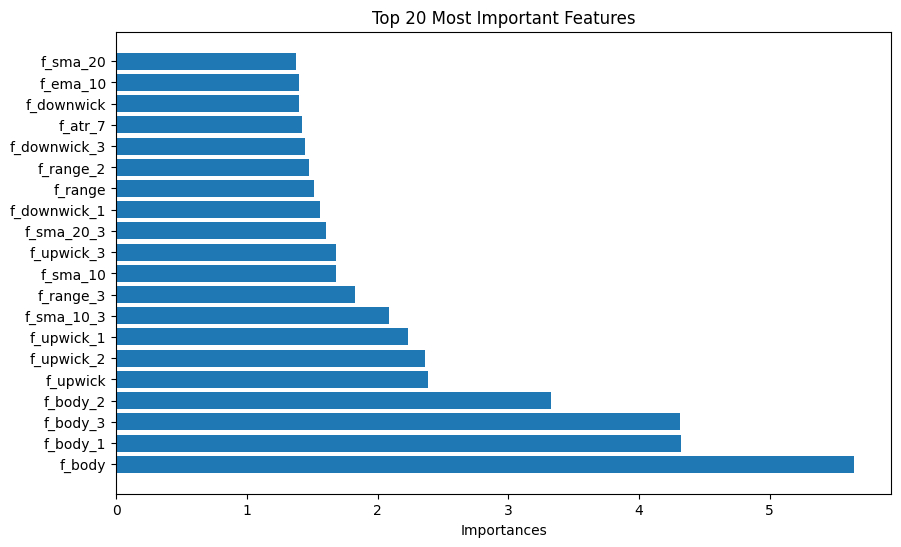

In [153]:
# Get Feature Importances
# importance scores
feature_importance = clf.get_feature_importance(prettified=True)

feature_importance = feature_importance.sort_values(by='Importances', ascending=False)


# Print the top 20 most important features
print("Top 20 most important features:")
top_features = feature_importance.head(20)['Feature Id'].values
print(top_features)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
plt.barh(range(20), feature_importance['Importances'].head(20), align='center')
plt.yticks(range(20), feature_importance['Feature Id'].head(20))
plt.xlabel('Importances')
plt.title('Top 20 Most Important Features')
plt.show()




In [161]:
X = df_train[top_features]
y = df_train[['target_clf', 'target_reg']]
target_clf = 'target_clf'
target_reg = 'target_reg'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [165]:


# Classifier
clf = CatBoostClassifier(iterations=1000, 
                         depth=16, 
                         learning_rate=0.05, 
                         loss_function='Logloss',
                         random_seed=42)
clf.fit(X_train, y_train[target_clf], eval_set=(X_test, y_test[target_clf]), verbose=False)

y_clf_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test[target_clf], y_clf_pred)
print(f'Accuracy: {accuracy:.2f}')

KeyboardInterrupt: 

In [ ]:
# Note
"""
BTC
CLF - 0.57
REG - 1.76

USDT
CLF - 0.65
reg: 1.74

Common crypto
CLF: 0.6
REG: 1.78

"""